## Final Project Combined Preliminary EDA

In [1]:
# import libraries

import numpy as np
from numpy import errstate,isneginf
import pandas as pd
from time import time
from datetime import datetime
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import re as re
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
sns.set(style = 'white')

%matplotlib inline

## Installing Reverse Geocoder
This helps us get county and city data against longtitude and latitude zillow data. Source: https://github.com/thampiman/reverse-geocoder

In [3]:
# only need to install one time if new
# !pip install reverse_geocoder
import reverse_geocoder as rg

## Reading in Data

In [7]:
# load the data 
#train_2016 = pd.read_csv("train_2016_v2.csv")
#properties_2016 = pd.read_csv("properties_2016.csv")
#Ray load in
#Comment this out, if you need to change it please.
train_2016 = pd.read_csv("~/GitHub/berkeley/W207/zillow_final_project/zillow-prize-1/train_2016_v2.csv")
properties_2016 = pd.read_csv("~/GitHub/berkeley/W207/zillow_final_project/zillow-prize-1/properties_2016.csv")

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Properties Data EDA

In [8]:
# look at properties 2016 dataframe
properties_2016.describe(include='all').transpose().sort_values(by='count')

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
storytypeid,1624,NaN,NaN,NaN,7,0,7,7,7,7,7
basementsqft,1628,NaN,NaN,NaN,646.883,538.793,20,272,534,847.25,8516
yardbuildingsqft26,2647,NaN,NaN,NaN,278.297,369.732,10,96,168,320,6141
fireplaceflag,5163,1,True,5163,NaN,NaN,NaN,NaN,NaN,NaN,NaN
architecturalstyletypeid,6061,NaN,NaN,NaN,7.20261,2.43629,2,7,7,7,27
typeconstructiontypeid,6747,NaN,NaN,NaN,5.99956,0.38405,4,6,6,6,13
finishedsquarefeet13,7672,NaN,NaN,NaN,1178.9,357.073,120,960,1296,1440,2688
buildingclasstypeid,12629,NaN,NaN,NaN,3.72595,0.5017,1,3,4,4,5
decktypeid,17096,NaN,NaN,NaN,66,0,66,66,66,66,66
finishedsquarefeet6,22001,NaN,NaN,NaN,2414.34,7695.3,117,1079,1992,3366,952576


# Ray doing some analysis on columns before dropping. Will clean up Wednesday. Separating categorical variables and continuous

In [9]:
# create the train and dev subsets from 2016 data
df = properties_2016.merge(train_2016, on='parcelid', how='inner',left_index=True,right_index=True, copy='False')
df.set_index(keys='parcelid',inplace=True)

# lookup lat/long locations
lat_long_pairs = list(zip(df['latitude'], 
                          df['longitude']))
results = rg.search(lat_long_pairs)

city = [result.get("name") for result in results]
county = [result.get("admin2") for result in results]

df['city'] = city
df['county'] = county

# create a combined variable for better categorization
df['county_city'] = list(zip(county, city))
df['county_city'] = df['county_city'].astype('category')

Loading formatted geocoded file...


In [11]:
print(df.columns)
print(len(df.columns))

Index(['airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft',
       'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'y

In [26]:
df[df.columns[0:20]].dtypes

airconditioningtypeid           float64
architecturalstyletypeid        float64
basementsqft                    float64
bathroomcnt                     float64
bedroomcnt                      float64
buildingclasstypeid             float64
buildingqualitytypeid           float64
calculatedbathnbr               float64
decktypeid                      float64
finishedfloor1squarefeet        float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet12            float64
finishedsquarefeet13            float64
finishedsquarefeet15            float64
finishedsquarefeet50            float64
finishedsquarefeet6             float64
fips                            float64
fireplacecnt                    float64
fullbathcnt                     float64
garagecarcnt                    float64
dtype: object

In [24]:
df[df.columns[20:40]].dtypes

garagetotalsqft              float64
hashottuborspa                object
heatingorsystemtypeid        float64
latitude                     float64
longitude                    float64
lotsizesquarefeet            float64
poolcnt                      float64
poolsizesum                  float64
pooltypeid10                 float64
pooltypeid2                  float64
pooltypeid7                  float64
propertycountylandusecode     object
propertylandusetypeid        float64
propertyzoningdesc            object
rawcensustractandblock       float64
regionidcity                 float64
regionidcounty               float64
regionidneighborhood         float64
regionidzip                  float64
roomcnt                      float64
dtype: object

In [25]:
df[df.columns[40:]].dtypes

storytypeid                    float64
threequarterbathnbr            float64
typeconstructiontypeid         float64
unitcnt                        float64
yardbuildingsqft17             float64
yardbuildingsqft26             float64
yearbuilt                      float64
numberofstories                float64
fireplaceflag                   object
structuretaxvaluedollarcnt     float64
taxvaluedollarcnt              float64
assessmentyear                 float64
landtaxvaluedollarcnt          float64
taxamount                      float64
taxdelinquencyflag              object
taxdelinquencyyear             float64
censustractandblock            float64
logerror                       float64
transactiondate                 object
city                            object
county                          object
county_city                   category
dtype: object

In [64]:
def cat_or_float(df):
    categorical_col = []
    continuous_col = []
    for i in df.columns:
        if type(df[i].iloc[1]) == str:
            categorical_col.append(i)
        if type(df[i].iloc[1]) == np.float64:
            continuous_col.append(i)
    return continuous_col, categorical_col

In [65]:
cont_col, cat_col = cat_or_float(df)

In [66]:
print(cont_col)
print(cat_col)

['airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid', 'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid', 'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet', 'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'propertylandusetypeid', 'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt', 'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid', 'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt', 'numberofstories', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt', 'taxamount', 'taxdelinquencyyear', 'census

# Something is wrong with city/county. Needs to be fixed. Probably won't create any dummies for any categorical variables except County + Interaction terms b/w counties.

In [73]:
#Add logerror into the cat_col
for i in cat_col:
    print('categorical column {0} contains {1} unique values for dummy columns'.format(i, len(df[i].unique())))
cat_col.append('logerror')
print(df['city'].unique())

categorical column propertycountylandusecode contains 109 unique values for dummy columns
categorical column propertyzoningdesc contains 2144 unique values for dummy columns
categorical column transactiondate contains 352 unique values for dummy columns
categorical column city contains 1 unique values for dummy columns
categorical column county contains 1 unique values for dummy columns
categorical column logerror contains 1894 unique values for dummy columns
categorical column logerror contains 1894 unique values for dummy columns
categorical column logerror contains 1894 unique values for dummy columns
['Egvekinot']


In [111]:
cat_df = df[cat_col]
con_df = df[cont_col]

In [49]:
df_dummies_cat = pd.get_dummies(cat_df)

In [52]:
print(df_dummies_cat.columns)

Index(['logerror', 'propertycountylandusecode_0',
       'propertycountylandusecode_0100', 'propertycountylandusecode_0101',
       'propertycountylandusecode_0102', 'propertycountylandusecode_0103',
       'propertycountylandusecode_0104', 'propertycountylandusecode_0108',
       'propertycountylandusecode_0109', 'propertycountylandusecode_010C',
       ...
       'transactiondate_2016-12-23', 'transactiondate_2016-12-24',
       'transactiondate_2016-12-25', 'transactiondate_2016-12-26',
       'transactiondate_2016-12-27', 'transactiondate_2016-12-28',
       'transactiondate_2016-12-29', 'transactiondate_2016-12-30',
       'city_Egvekinot', 'county_'],
      dtype='object', length=2606)


# Going to plot corr of continuous variables (53 variables)

In [112]:
print(con_df.columns)

Index(['airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft',
       'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertylandusetypeid', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt',
       'numberofstories', 'structuretaxvaluedollarcnt', 'taxvalue

In [113]:
def col_append(col_ind):
    col = cont_col[col_ind:col_ind+10]
    col.append('logerror')
    return col

In [125]:
df1, df2, df3, df4, df5 = con_df[col_append(0)], con_df[col_append(10)], con_df[col_append(20)], con_df[col_append(30)], con_df[col_append(40)]
df6 = con_df[con_df.columns[50:]]


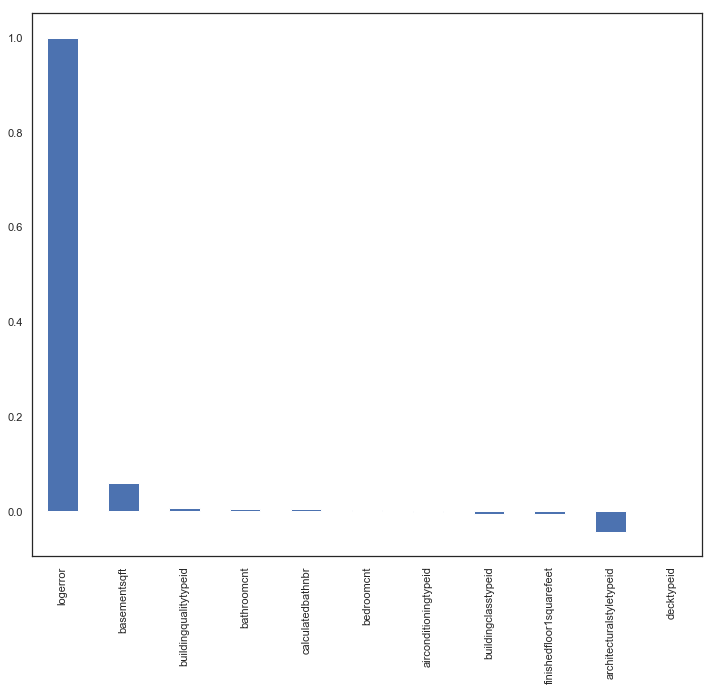

In [115]:
#Get Correlation of "Churn" with other variables:
plt.figure(figsize=(12,10))
df1.corr()['logerror'].sort_values(ascending = False).plot(kind='bar')

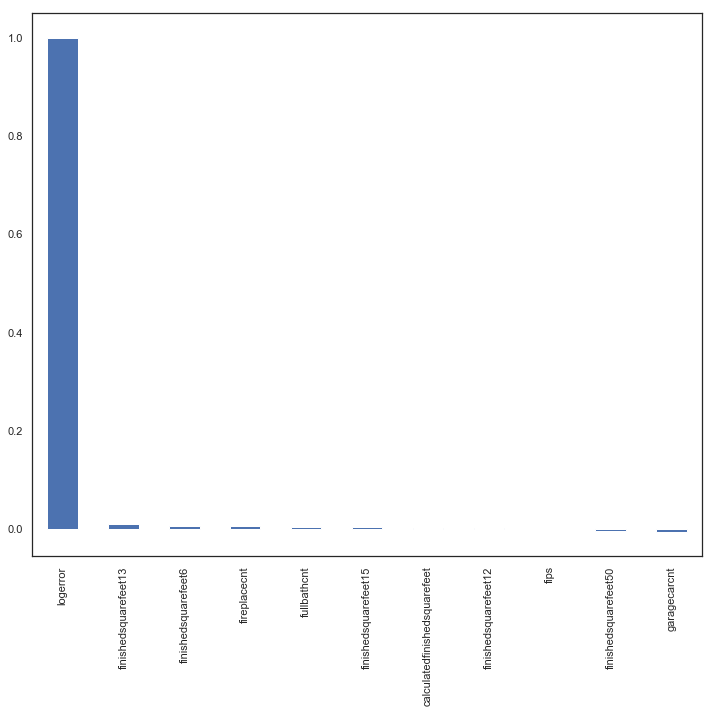

In [116]:
#Get Correlation of "Churn" with other variables:
plt.figure(figsize=(12,10))
df2.corr()['logerror'].sort_values(ascending = False).plot(kind='bar')

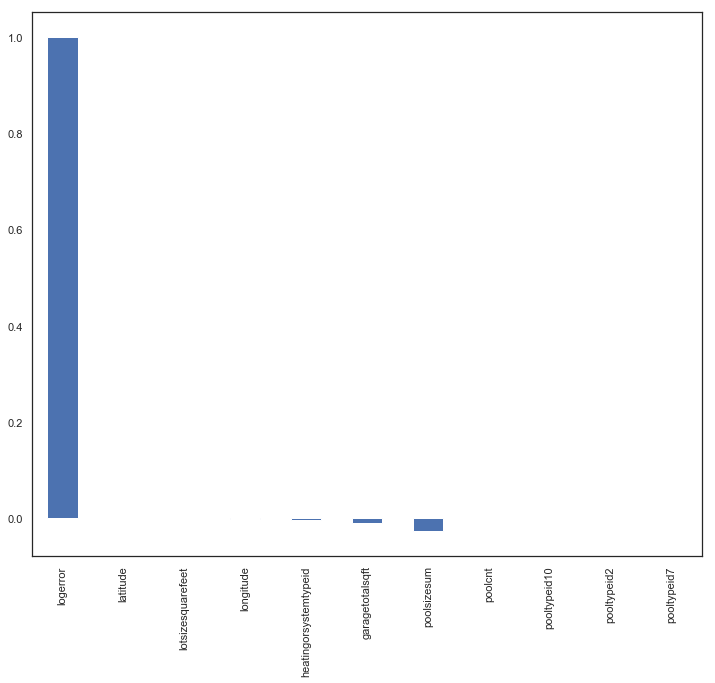

In [117]:
#Get Correlation of "Churn" with other variables:
plt.figure(figsize=(12,10))
df3.corr()['logerror'].sort_values(ascending = False).plot(kind='bar')

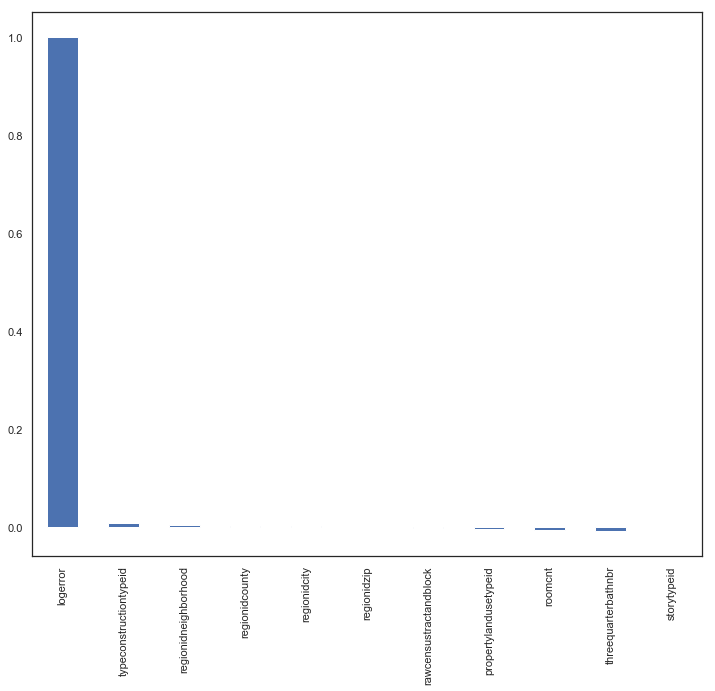

In [118]:
#Get Correlation of "Churn" with other variables:
plt.figure(figsize=(12,10))
df4.corr()['logerror'].sort_values(ascending = False).plot(kind='bar')

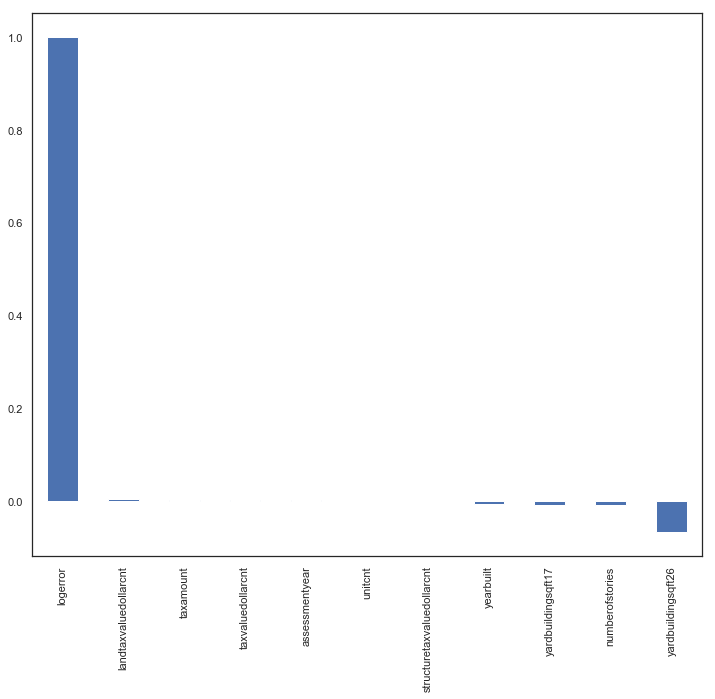

In [119]:
#Get Correlation of "Churn" with other variables:
plt.figure(figsize=(12,10))
df5.corr()['logerror'].sort_values(ascending = False).plot(kind='bar')

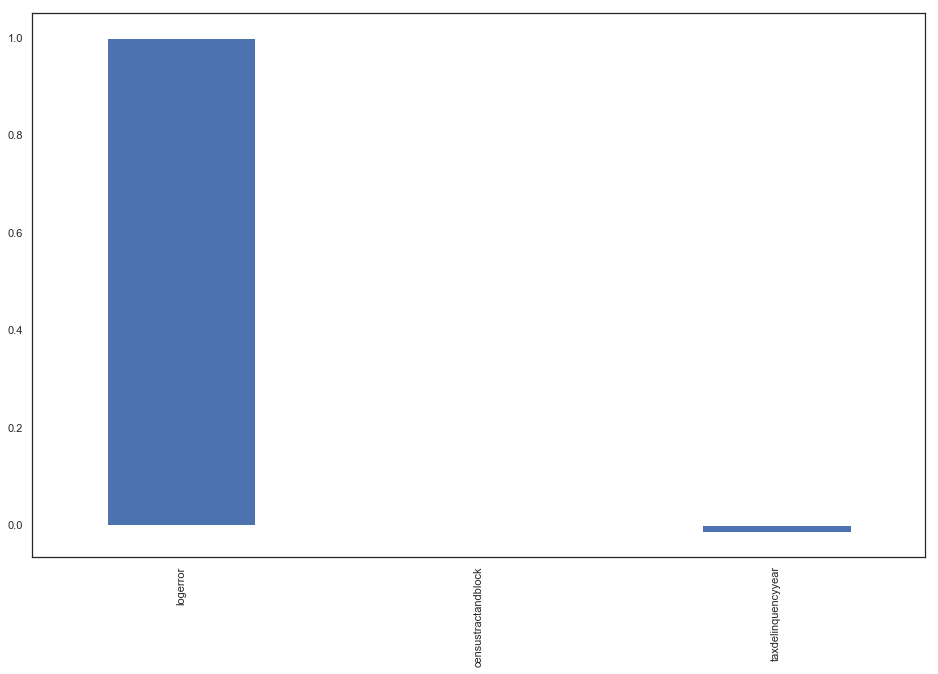

In [126]:
#Get Correlation of "Churn" with other variables:
plt.figure(figsize=(16,10))
df6.corr()['logerror'].sort_values(ascending = False).plot(kind='bar')

In [5]:
# Drop sparsely populated columns
properties_2016.drop(labels=['storytypeid','basementsqft','yardbuildingsqft26','architecturalstyletypeid',
                'architecturalstyletypeid','finishedsquarefeet13','buildingclasstypeid','finishedsquarefeet6',
               'finishedsquarefeet15','finishedsquarefeet50','finishedfloor1squarefeet'], axis=1,inplace=True)

# drop categorical columns for now
# TODO create dummy variables
properties_2016.drop(labels=['buildingqualitytypeid', 'decktypeid', 'fips', 'heatingorsystemtypeid', 
                'propertylandusetypeid', 'rawcensustractandblock', 'regionidcity', 'regionidcounty', 
                'regionidneighborhood', 'regionidzip', 'typeconstructiontypeid', 'censustractandblock'], 
        axis=1,inplace=True)

# drop those with no variation or those covered by other categories
properties_2016.drop(labels=['propertycountylandusecode', 'propertyzoningdesc','fireplaceflag','assessmentyear','taxdelinquencyyear'], 
        axis=1,inplace=True)

In [6]:
properties_2016.dtypes.transpose()

parcelid                          int64
airconditioningtypeid           float64
bathroomcnt                     float64
bedroomcnt                      float64
calculatedbathnbr               float64
calculatedfinishedsquarefeet    float64
finishedsquarefeet12            float64
fireplacecnt                    float64
fullbathcnt                     float64
garagecarcnt                    float64
garagetotalsqft                 float64
hashottuborspa                   object
latitude                        float64
longitude                       float64
lotsizesquarefeet               float64
poolcnt                         float64
poolsizesum                     float64
pooltypeid10                    float64
pooltypeid2                     float64
pooltypeid7                     float64
roomcnt                         float64
threequarterbathnbr             float64
unitcnt                         float64
yardbuildingsqft17              float64
yearbuilt                       float64


In [7]:
# standardize and convert data to 1 or 0
def convert_yn(x):
    if x in ['True','Y']:
        return 1
    return 0

properties_2016['hashottuborspa'] = properties_2016['hashottuborspa'].map(convert_yn)
properties_2016['taxdelinquencyflag'] = properties_2016['taxdelinquencyflag'].map(convert_yn)

In [8]:
# Interpolate missing values for the following columns
interpolate_columns = ['structuretaxvaluedollarcnt', 'taxvaluedollarcnt', \
                      'landtaxvaluedollarcnt', 'taxamount', 'lotsizesquarefeet', \
                      'garagetotalsqft']

# default interpolation method is linear, let's just stick with that
for column in interpolate_columns:
    properties_2016[column].interpolate(inplace=True)

In [22]:
# transform columns with very large st dev to log
log_transform_columns = ['structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', \
                        'taxamount', 'lotsizesquarefeet', 'garagetotalsqft']

eps = 1e-6
for column in log_transform_columns:
    properties_2016[column] = np.log10(properties_2016[column] + eps)


/opt/anaconda3/envs/jupyter3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys


In [27]:
# normalize continuous variables
normalize_columns = ['calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'garagetotalsqft', \
                     'lotsizesquarefeet', 'poolsizesum', 'yardbuildingsqft17', \
                    'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt',
                    'taxamount']

for column in normalize_columns:
    properties_2016[column] = (properties_2016[column] - properties_2016[column].mean()) / properties_2016[column].std()

-4.012739247921206e-18
-3.6259085104161935e-17
3.103268401465296e-15
-1.7061306866229148e-17
-2.5428713339411668e-17
1.8091295232956008e-17
3.2274834888714934e-15
2.0136912095060993e-15
-1.2996526671898565e-14
2.126266792734616e-15


In [10]:
# Convert Lat/Long to actual Lat/Long
properties_2016['latitude'] = properties_2016['latitude']/1e6
properties_2016['longitude'] = properties_2016['longitude']/1e6

In [26]:
properties_2016.shape
properties_2016.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
parcelid,2985217.0,1.332586e+07,7.909966e+06,1.071172e+07,1.164371e+07,1.254509e+07,1.409712e+07,1.696019e+08
airconditioningtypeid,811519.0,1.931166e+00,3.148587e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.300000e+01
bathroomcnt,2973755.0,2.209143e+00,1.077754e+00,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,2.000000e+01
bedroomcnt,2973767.0,3.088949e+00,1.275859e+00,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,2.000000e+01
calculatedbathnbr,2856305.0,2.299263e+00,1.000736e+00,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,2.000000e+01
calculatedfinishedsquarefeet,2929652.0,-4.012739e-18,1.000000e+00,-1.003507e+00,-3.374924e-01,-1.402159e-01,1.697116e-01,5.224525e+02
finishedsquarefeet12,2709184.0,-3.625909e-17,1.000000e+00,-1.811421e+00,-5.808086e-01,-2.275867e-01,3.192378e-01,2.971852e+02
fireplacecnt,312637.0,1.168710e+00,4.612729e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.000000e+00
fullbathcnt,2856305.0,2.244165e+00,9.912054e-01,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,2.000000e+01
garagecarcnt,883267.0,1.823517e+00,6.100354e-01,0.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.500000e+01


## Train Data ETA

In [12]:
train_2016.transactiondate = pd.to_datetime(train_2016.transactiondate, infer_datetime_format=True)
train_2016.set_index(keys='parcelid',inplace=True)
print(train_2016.shape)
print(train_2016.dtypes)

(90275, 2)
logerror                  float64
transactiondate    datetime64[ns]
dtype: object


## Merge train + properties data

In [13]:
# create the train and dev subsets from 2016 data
df = properties_2016.merge(train_2016, on='parcelid', how='inner',left_index=True,right_index=True, copy='False')
df.set_index(keys='parcelid',inplace=True)

## Retrieve Geocode Data

In [70]:
# lookup lat/long locations
lat_long_pairs = list(zip(df['latitude'], 
                          df['longitude']))
results = rg.search(lat_long_pairs)

city = [result.get("name") for result in results]
county = [result.get("admin2") for result in results]

df['city'] = city
df['county'] = county

# create a combined variable for better categorization
df['county_city'] = list(zip(county, city))
df['county_city'] = df['county_city'].astype('category')

## Split dataset into train and dev

In [15]:
# split the dataset into train and dev
df = shuffle(df)

train_data, train_labels = df.iloc[int(len(df)/2):, 0:29], df.iloc[int(len(df)/2):, 29:30].values
df_train = df.iloc[int(len(df)/2):, :]
dev_data, dev_labels = df.iloc[:int(len(df)/2), 0:29], df.iloc[:int(len(df)/2), 29:30].values
print(train_data.shape)


(45138, 29)


## <font color=red> This is the start of feature exploration, selection, and engineering... </font>

/opt/anaconda3/envs/jupyter3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/anaconda3/envs/jupyter3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/opt/anaconda3/envs/jupyter3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


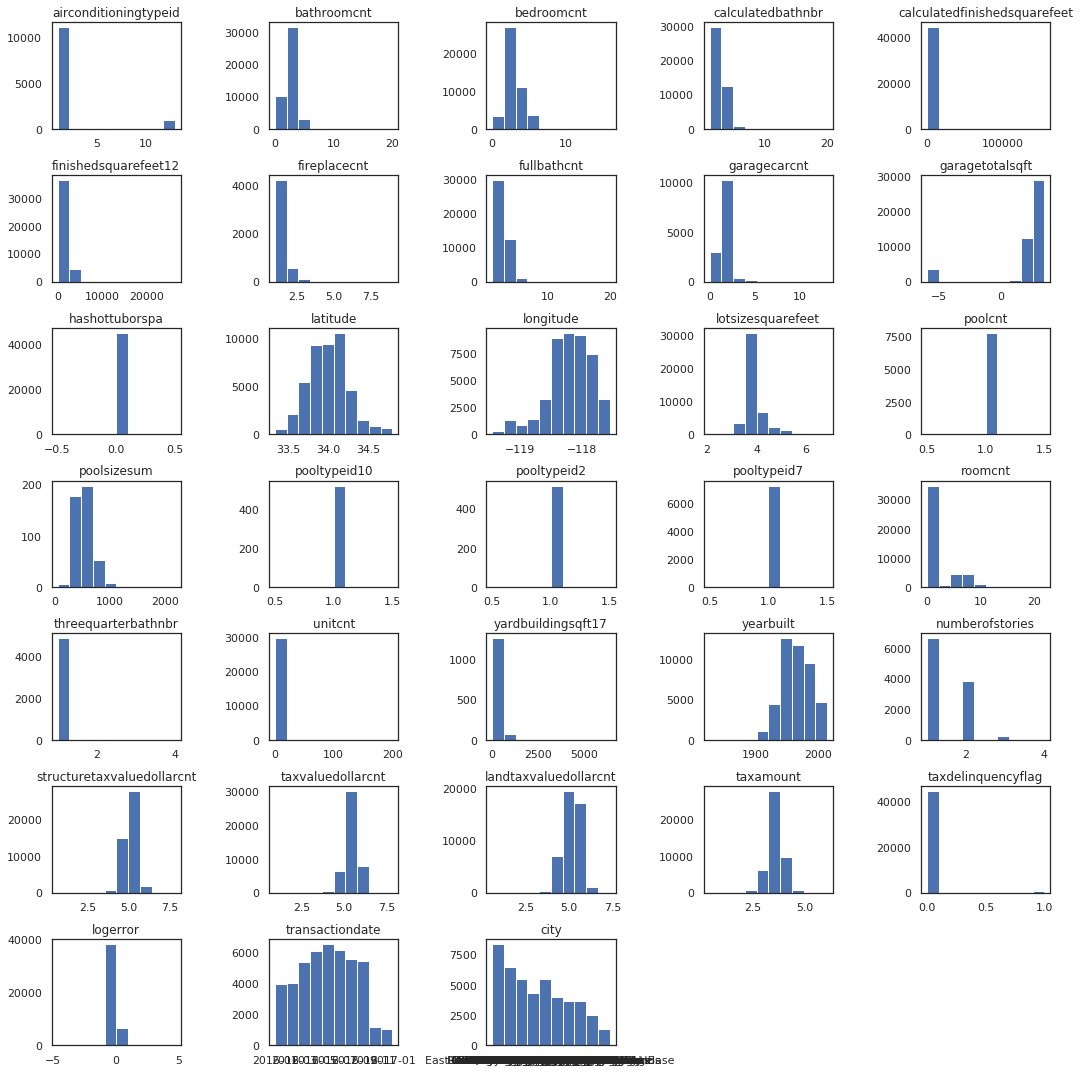

In [16]:
# plot distribution histograms of features 
def plt_hist(df,row,col,cnt):
    fig, ax = plt.subplots(row,col, figsize=(15,15))
    ax = ax.flatten()
    i = 0
    for c in df.columns:
        ax[i].hist(df[c])
        ax[i].set_xlabel("")
        ax[i].set_ylabel("")
        ax[i].set_title(c)
        i+=1
    if cnt < row*col:
        for i in range(cnt,row*col):
            plt.delaxes(ax[i])
    plt.tight_layout()

plt_hist(df_train,7,5,len(df_train.columns)-2)

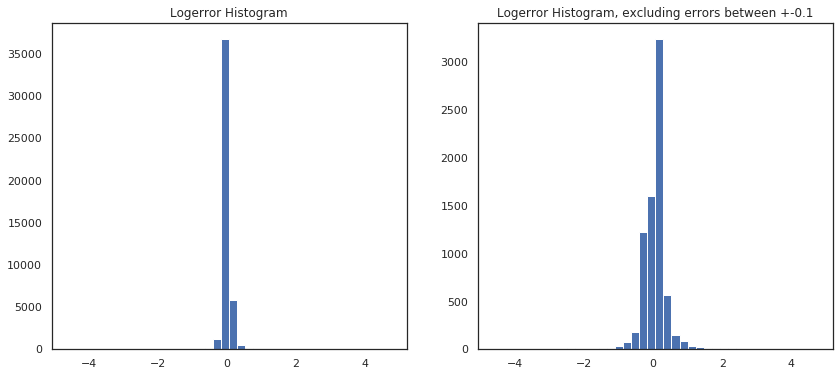

In [17]:
# plot histograms of Logerrors
fig, ax = plt.subplots(1,2, figsize=(14,6))

ax.flatten()
ax[0].hist(df_train.logerror,bins=40)
ax[0].set_title("Logerror Histogram")
ax[1].hist(df_train.logerror[np.abs(df_train.logerror) >= 0.1],bins=40)
ax[1].set_title("Logerror Histogram, excluding errors between +-0.1")
plt.show()

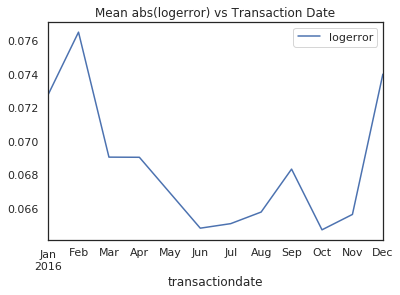

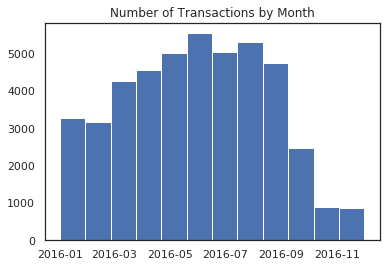

In [18]:
# plot logerrors over time
plt_df = df_train[['transactiondate','logerror']].copy()
plt_df['transactiondate'] = plt_df.transactiondate.astype('datetime64[M]')
plt_df['logerror'] = np.abs(plt_df.logerror)
g = plt_df.groupby(['transactiondate']).mean()
g.plot()
plt.title("Mean abs(logerror) vs Transaction Date")
plt.show()
plt.hist(plt_df.transactiondate,bins=12)
plt.title("Number of Transactions by Month")
plt.show()

In [19]:
# make new dataframe with absolute logerror
new_df = df_train.copy()

new_df['transactiondate'] = new_df.transactiondate.astype('datetime64[M]')
new_df['abs_logerror'] = np.abs(new_df.logerror)
new_df = new_df[new_df.transactiondate == '2016-12-01']
new_df.sort_values(by=['abs_logerror'],inplace=True, ascending=False)

new_df.head(8).transpose()

parcelid,11483483,17149490,17200278,12556281,11187213,17131371,14163536,17112509
airconditioningtypeid,1,NaN,NaN,NaN,1,NaN,NaN,NaN
bathroomcnt,3,2,2.5,1,3,2.5,5.5,2.5
bedroomcnt,3,4,3,1,5,2,5,3
calculatedbathnbr,3,2,2.5,1,3,2.5,5.5,2.5
calculatedfinishedsquarefeet,1850,1863,1934,750,3147,2224,4630,1525
finishedsquarefeet12,1850,1863,1934,750,3147,2224,4630,1525
fireplacecnt,NaN,1,NaN,NaN,NaN,1,NaN,NaN
fullbathcnt,3,2,2,1,3,2,5,2
garagecarcnt,NaN,2,2,NaN,NaN,1,2,2
garagetotalsqft,2.22051,2.70415,-6,2.54654,2.86972,2.50515,2.81757,2.64147


## Normalize Continuous Variables

In [20]:
norm_df = df.copy()
norm_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
airconditioningtypeid,24366.0,1.967167,3.206663,1.000000e+00,1.000000,1.000000,1.000000,13.000000
bathroomcnt,90275.0,2.204508,1.084413,0.000000e+00,2.000000,2.000000,3.000000,20.000000
bedroomcnt,90275.0,3.077917,1.282892,0.000000e+00,2.000000,3.000000,4.000000,16.000000
calculatedbathnbr,86420.0,2.301967,1.001528,1.000000e+00,2.000000,2.000000,3.000000,20.000000
calculatedfinishedsquarefeet,88908.0,1830.879583,1550.178793,1.000000e+00,1215.000000,1573.000000,2141.000000,161232.000000
finishedsquarefeet12,82353.0,1763.107841,999.702554,1.000000e+00,1198.000000,1540.000000,2077.000000,115554.000000
fireplacecnt,9929.0,1.166683,0.467857,1.000000e+00,1.000000,1.000000,1.000000,9.000000
fullbathcnt,86420.0,2.245383,0.991980,1.000000e+00,2.000000,2.000000,3.000000,20.000000
garagecarcnt,27475.0,1.821256,0.612683,0.000000e+00,2.000000,2.000000,2.000000,13.000000
garagetotalsqft,90029.0,1.943398,2.364846,-6.000000e+00,2.562907,2.662758,2.753459,3.576802


In [21]:
normalize_columns = ['calculatedfinishedsquarefeet', 'finishedsquarefeet12', '']